### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# carregar o .env com as credenciais
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")


# detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"


# parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.sales-salesorderdetail"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"


# configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


#doc: tables_to_process: lista de tabelas que serão processadas
#     output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned

In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.sales-salesorderdetail']


In [3]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productcosthistory
production-productinventory
production-productsubcategory
purchasing-purchaseorderdetail
purchasing-purchaseorderheader
purchasing-vendor
sales-creditcard
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesperson
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [4]:
# Setup inicial do df para realizar a EDA 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [5]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.raw_data.sales-salesorderdetail
Lendo os dados do BigQuery...
Tabela sales_salesorderdetail processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [6]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: sales_salesorderdetail


In [7]:
# Atribuir o df a uma variável com nome mais simples
sales_salesorderdetail = df_processados['sales_salesorderdetail']

print(f"Colunas: {sales_salesorderdetail.shape[1]}\nLinhas: {sales_salesorderdetail.shape[0]}")

Colunas: 10
Linhas: 1577121


In [8]:
# Identificar duplicadas
duplicadas = sales_salesorderdetail[sales_salesorderdetail.duplicated(subset=['salesorderdetailid'], keep=False)]

# Verificar se existem duplicadas
if not duplicadas.empty:
    
    duplicadas_ordenadas = duplicadas.sort_values(by=['salesorderdetailid', 'modifieddate'])

    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
         salesorderid  salesorderdetailid carriertrackingnumber  orderqty  productid  specialofferid  unitprice  unitpricediscount                               rowguid              modifieddate
23174           43659                   1          4911-403C-98         1        776               1    2024.99               0.00  b207c96d-d9e6-402b-8470-2cc176c42283 2011-05-31 00:00:00+00:00
195471          43659                   1          4911-403C-98         1        776               1    2024.99               0.00  b207c96d-d9e6-402b-8470-2cc176c42283 2011-05-31 00:00:00+00:00
361706          43659                   1          4911-403C-98         1        776               1    2024.99               0.00  b207c96d-d9e6-402b-8470-2cc176c42283 2011-05-31 00:00:00+00:00
426167          43659                   1          4911-403C-98         1        776               1    2024.99               0.00  b207c96d-d9e6-402b-8470-2cc176c42283 2011-05-31 00:00:00+00:00
577

In [9]:
# Remover duplicadas* 
sales_salesorderdetail = sales_salesorderdetail.drop_duplicates(subset=['salesorderdetailid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(sales_salesorderdetail)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = sales_salesorderdetail.copy()


#doc: bkp = backup (cópia)
#doc*: mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
#      Importante, pois se houver erro na ingestão (duplicação), mantém os dados íntegros.

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 121317


In [10]:
# Ordenar e exibir o df por 'salesorderdetailid'
sales_salesorderdetail = sales_salesorderdetail.sort_values(by=['salesorderdetailid'])

print(sales_salesorderdetail)

         salesorderid  salesorderdetailid carriertrackingnumber  orderqty  productid  specialofferid  unitprice  unitpricediscount                               rowguid              modifieddate
1470407         43659                   1          4911-403C-98         1        776               1    2024.99               0.00  b207c96d-d9e6-402b-8470-2cc176c42283 2011-05-31 00:00:00+00:00
1470408         43659                   2          4911-403C-98         3        777               1    2024.99               0.00  7abb600d-1e77-41be-9fe5-b9142cfc08fa 2011-05-31 00:00:00+00:00
1551126         43659                   3          4911-403C-98         1        778               1    2024.99               0.00  475cf8c6-49f6-486e-b0ad-afc6a50cdd2f 2011-05-31 00:00:00+00:00
1511054         43659                   4          4911-403C-98         1        771               1    2039.99               0.00  04c4de91-5815-45d6-8670-f462719fbce3 2011-05-31 00:00:00+00:00
1551353         43659    

In [11]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in sales_salesorderdetail.columns:   
    missing_rows = sales_salesorderdetail[sales_salesorderdetail[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'salesorderid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salesorderid'.

Coluna 'salesorderdetailid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'salesorderdetailid'.

Coluna 'carriertrackingnumber': 60398 linhas ausentes.
Exibindo as primeiras linhas com valores ausentes em 'carriertrackingnumber':
         salesorderid  salesorderdetailid carriertrackingnumber  orderqty  productid  specialofferid  unitprice  unitpricediscount                               rowguid              modifieddate
1469441         43697                 353                  None         1        749               1    3578.27               0.00  ca258bf8-1f52-4ae6-8e8f-5439ae0c9509 2011-05-31 00:00:00+00:00
1456857         43698                 354                  None         1        773               1    3399.99               0.00  a2d7730f-d2d0-4c47-8f36-fbd316680cef 2011-05-31 00:00:00+00:00
1456858         43699                 355                  None         1   

In [12]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = sales_salesorderdetail.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)

Valores únicos incluindo NaN:
salesorderid              31465
salesorderdetailid       121317
carriertrackingnumber      3807
orderqty                     41
productid                   266
specialofferid               12
unitprice                   287
unitpricediscount             9
rowguid                  121317
modifieddate               1124
dtype: int64


In [13]:
#verificar informações do df
sales_salesorderdetail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121317 entries, 1470407 to 1493120
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   salesorderid           121317 non-null  Int64              
 1   salesorderdetailid     121317 non-null  Int64              
 2   carriertrackingnumber  60919 non-null   object             
 3   orderqty               121317 non-null  Int64              
 4   productid              121317 non-null  Int64              
 5   specialofferid         121317 non-null  Int64              
 6   unitprice              121317 non-null  float64            
 7   unitpricediscount      121317 non-null  float64            
 8   rowguid                121317 non-null  object             
 9   modifieddate           121317 non-null  datetime64[us, UTC]
dtypes: Int64(5), datetime64[us, UTC](1), float64(2), object(2)
memory usage: 10.8+ MB


In [14]:
# Variáveis quantitativas*: estatísticas descritivas para verificar se ainda há o que ser feito antes de exportar os dados ao BigQuery

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['orderqty', 'unitprice','unitpricediscount']

# Estatísticas Descritivas das colunas numéricas*
print(sales_salesorderdetail[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)**
for col in numeric_columns:
    q1 = sales_salesorderdetail[col].quantile(0.25)
    q3 = sales_salesorderdetail[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers***
    outliers = sales_salesorderdetail[(sales_salesorderdetail[col] < lower_bound) | (sales_salesorderdetail[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])


#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas, no nosso caso, vacationhours, sickleavehours, por exemplo
#doc*: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc**: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc***: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados

#doc****: as colunas analisadas apresentam outliers, porém os dados refletem operações reais da AdventureWorks, 
#         incluindo pedidos, preços, e descontos. Outliers em colunas como orderqty, unitprice, e unitpricediscount podem representar transações legítimas, 
#         como compras em grandes volumes, produtos premium, ou campanhas promocionais. Resultando em não manipular tais colunas.

       orderqty  unitprice  unitpricediscount
count 121317.00  121317.00          121317.00
mean       2.27     465.09               0.00
std        2.49     751.89               0.02
min        1.00       1.33               0.00
25%        1.00      21.49               0.00
50%        1.00      49.99               0.00
75%        3.00     602.35               0.00
max       44.00    3578.27               0.40

Coluna: orderqty
Limite inferior: -2.0, Limite superior: 6.0
Outliers detectados (6927):
         orderqty
1495222         7
1454827         7
1188386         9
1214811         8
1453761        10
...           ...
1465263         9
1316164        15
1513124        10
1348769        10
1552851         7

[6927 rows x 1 columns]

Coluna: unitprice
Limite inferior: -849.794, Limite superior: 1473.63
Outliers detectados (11439):
         unitprice
1470407    2024.99
1470408    2024.99
1551126    2024.99
1511054    2039.99
1551353    2039.99
...            ...
1512979    2319.99
151

c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


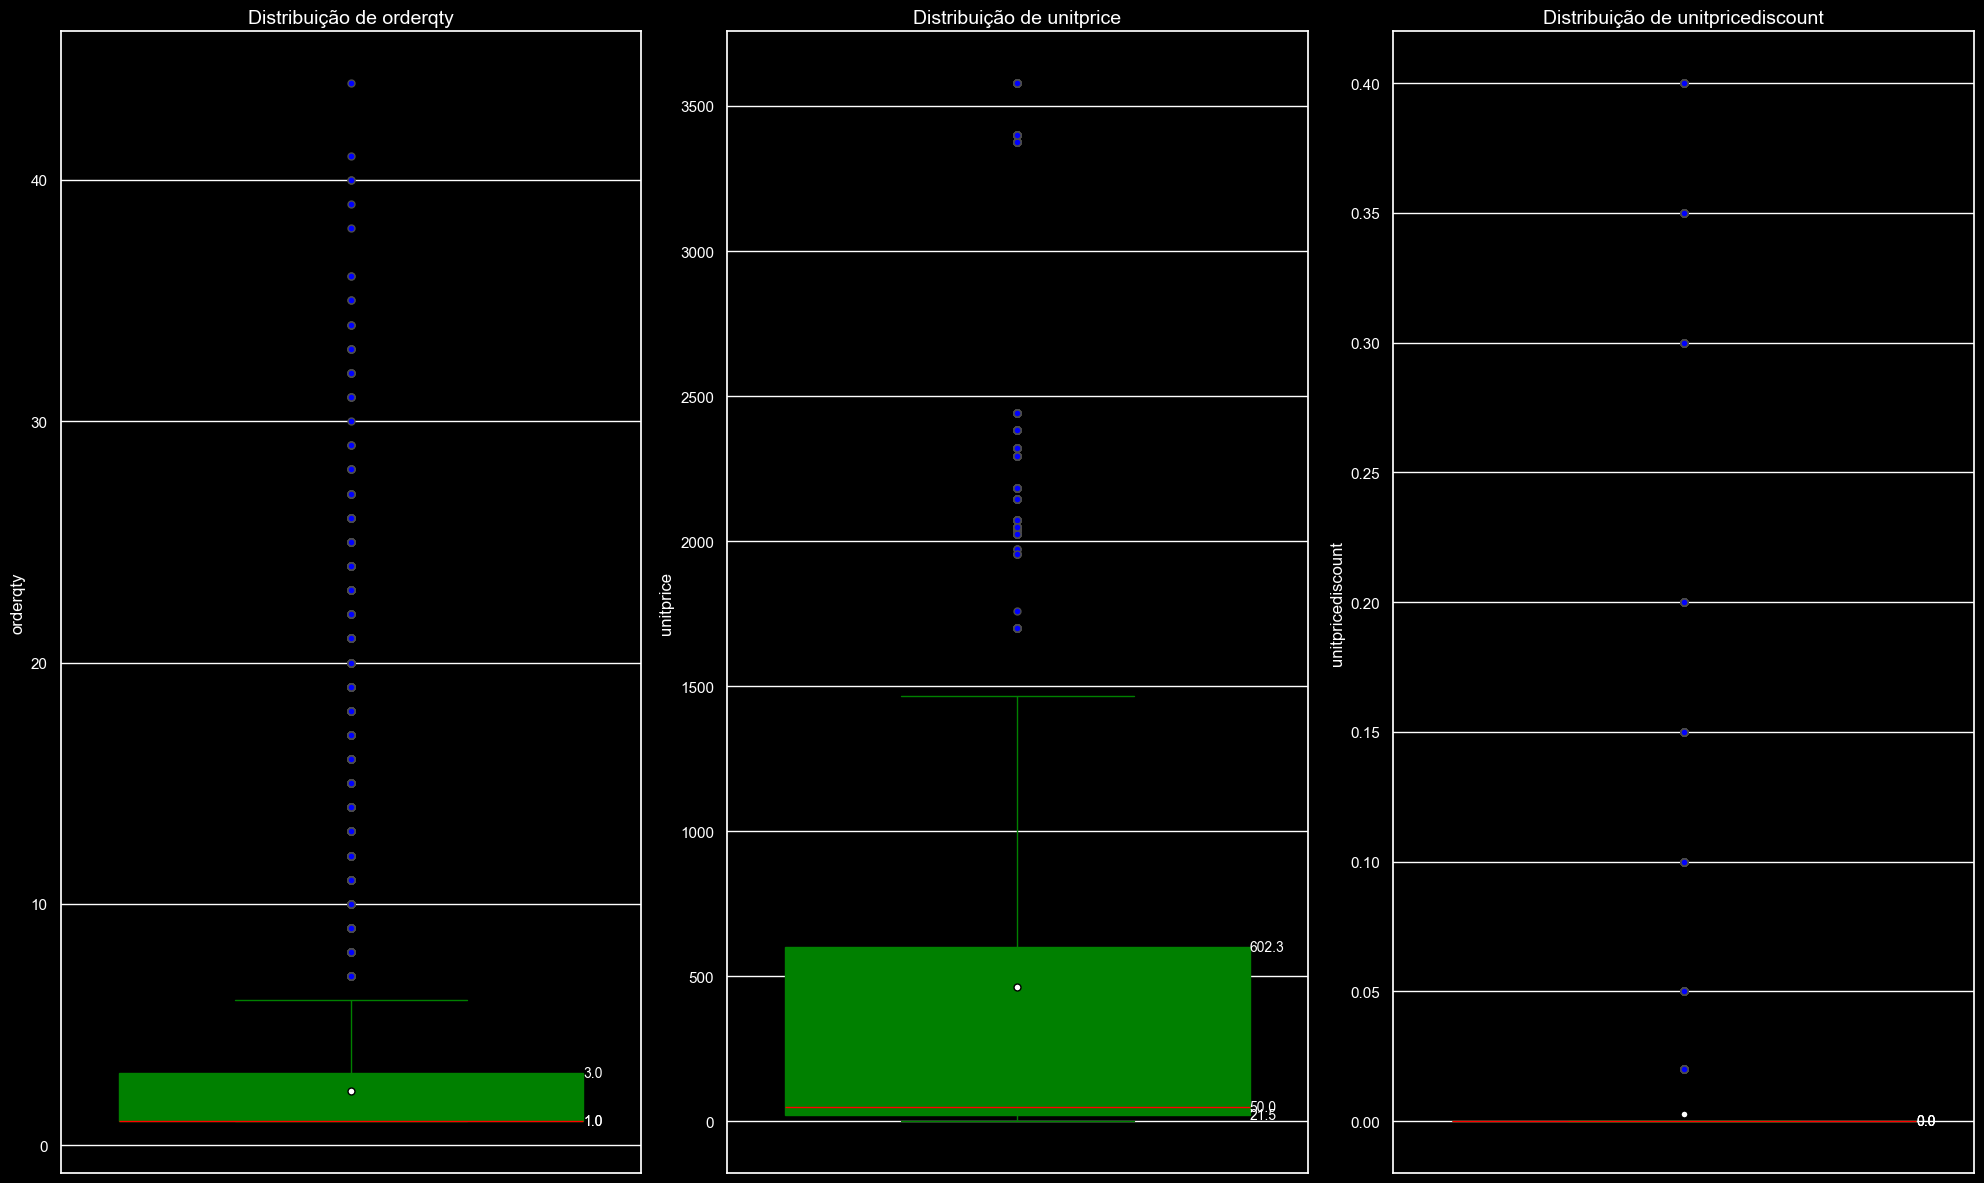

In [15]:
# Configurar o gráfico
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# Lista das colunas para análise
columns_to_plot = ['orderqty', 'unitprice', 'unitpricediscount']

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 12))  

for ax, col in zip(axes, columns_to_plot):
    quartiles = sales_salesorderdetail[col].quantile([0.25, 0.50, 0.75])

    sns.boxplot(
        y=sales_salesorderdetail[col], ax=ax, showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 5},
        boxprops={"color": "green"}, whiskerprops={"color": "green"}, capprops={"color": "green"},
        medianprops={"color": "red"}, flierprops={"markerfacecolor": "blue", "markersize": 5}
    )

    ax.set_title(f'Distribuição de {col}', color='white', fontsize=14)
    ax.set_ylabel(col, color='white', fontsize=12)
    ax.set_xlabel("")
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    offset = 0.4
    for i, quartile in enumerate(quartiles):
        y_pos = quartile
        ax.text(x=0 + offset, y=y_pos, s=f"{quartile:.1f}", ha='left', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

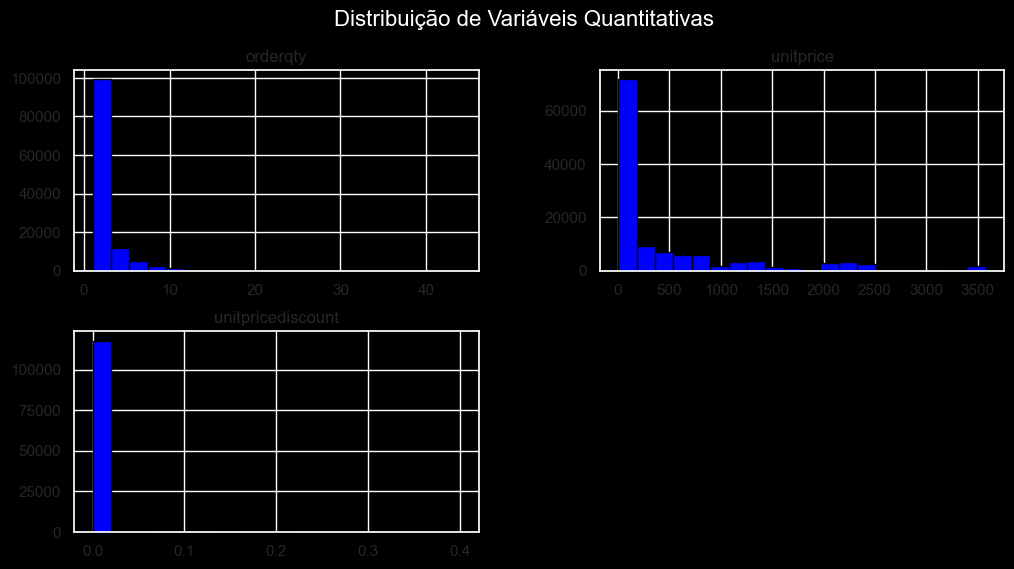

In [16]:
# Tipo histogramas*
sales_salesorderdetail[['orderqty', 'unitprice', 'unitpricediscount']].hist(
    bins=20, figsize=(12, 6), color='blue', edgecolor='black'
)
plt.suptitle("Distribuição de Variáveis Quantitativas", fontsize=16, color='white')
plt.grid(False)
plt.show()


#doc*: visualizar as distribuições de orderqty, unitprice e unitpricediscount

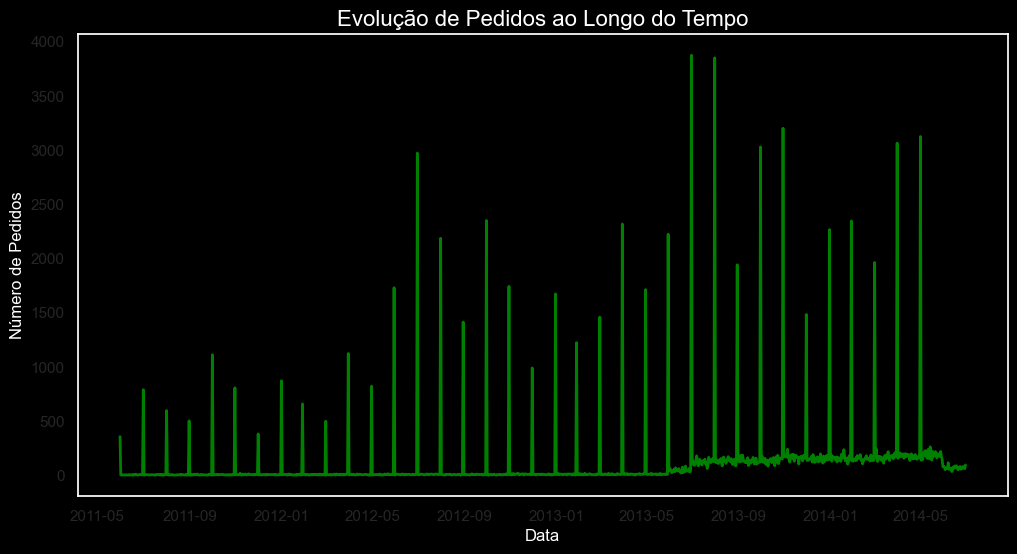

In [17]:
# Agrupar por data e contar pedidos
time_analysis = sales_salesorderdetail.groupby(sales_salesorderdetail['modifieddate'].dt.date).size()

plt.figure(figsize=(12, 6))
time_analysis.plot(color='green', linewidth=2)
plt.title("Evolução de Pedidos ao Longo do Tempo", fontsize=16, color='white')
plt.ylabel("Número de Pedidos", color='white')
plt.xlabel("Data", color='white')
plt.grid(False)
plt.show()


#doc*: entender como os dados evoluem ao longo do tempo

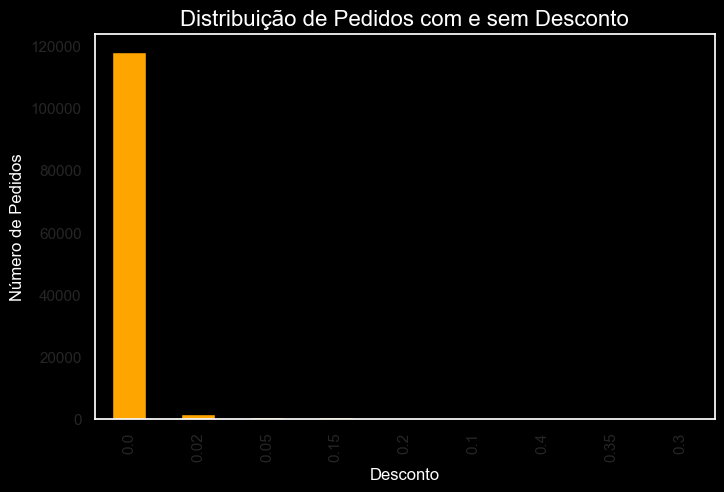

In [18]:
# Contar pedidos com desconto e sem desconto*
discount_counts = sales_salesorderdetail['unitpricediscount'].value_counts()

plt.figure(figsize=(8, 5))
discount_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Distribuição de Pedidos com e sem Desconto", fontsize=16, color='white')
plt.ylabel("Número de Pedidos", color='white')
plt.xlabel("Desconto", color='white')
plt.grid(False)
plt.show()


#doc*: verificar como os descontos (unitpricediscount) estão distribuídos

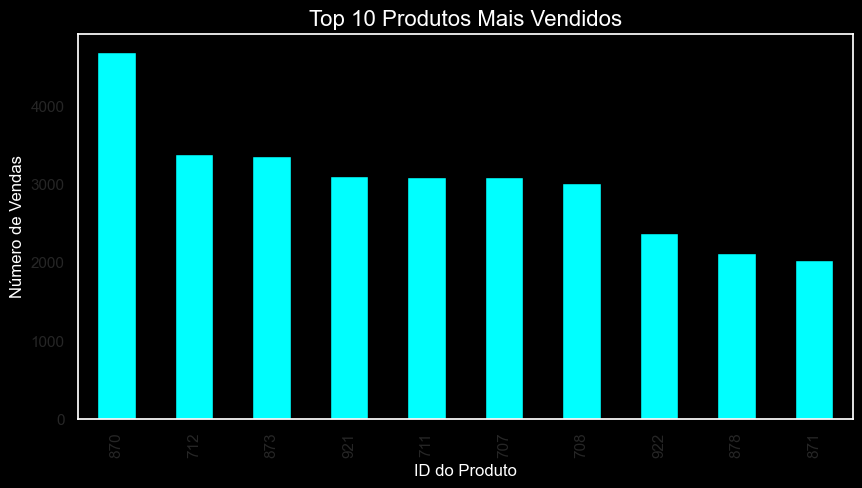

In [19]:
# Produtos mais vendidos
top_products = sales_salesorderdetail['productid'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_products.plot(kind='bar', color='cyan', edgecolor='black')
plt.title("Top 10 Produtos Mais Vendidos", fontsize=16, color='white')
plt.ylabel("Número de Vendas", color='white')
plt.xlabel("ID do Produto", color='white')
plt.grid(False)
plt.show()


#doc*: identificar os produtos mais vendidos

In [20]:
# Análise cruzada entre 'specialofferid' e 'productid'*
offer_product = sales_salesorderdetail.groupby(['specialofferid', 'productid']).size().reset_index(name='counts')

# Exibir os 10 principais
print(offer_product.sort_values(by='counts', ascending=False).head(10))


#doc*: verificar a relação entre specialofferid e productid

     specialofferid  productid  counts
139               1        870    4633
5                 1        712    3270
188               1        921    3095
0                 1        707    2979
4                 1        711    2968
1                 1        708    2887
142               1        873    2510
189               1        922    2376
147               1        878    2121
140               1        871    2025


In [21]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['sales_salesorderdetail'] = sales_salesorderdetail

In [22]:
# Padronizar colunas com valores textuais
sales_salesorderdetail['carriertrackingnumber'] = sales_salesorderdetail['carriertrackingnumber'].str.strip().str.upper()
sales_salesorderdetail['rowguid'] = sales_salesorderdetail['rowguid'].str.strip().str.upper()

print(sales_salesorderdetail.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

         salesorderid  salesorderdetailid carriertrackingnumber  orderqty  productid  specialofferid  unitprice  unitpricediscount                               rowguid              modifieddate
1470407         43659                   1          4911-403C-98         1        776               1    2024.99               0.00  B207C96D-D9E6-402B-8470-2CC176C42283 2011-05-31 00:00:00+00:00
1470408         43659                   2          4911-403C-98         3        777               1    2024.99               0.00  7ABB600D-1E77-41BE-9FE5-B9142CFC08FA 2011-05-31 00:00:00+00:00
1551126         43659                   3          4911-403C-98         1        778               1    2024.99               0.00  475CF8C6-49F6-486E-B0AD-AFC6A50CDD2F 2011-05-31 00:00:00+00:00
1511054         43659                   4          4911-403C-98         1        771               1    2039.99               0.00  04C4DE91-5815-45D6-8670-F462719FBCE3 2011-05-31 00:00:00+00:00
1551353         43659    

In [23]:
# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
 
    output_table = f"{output_dataset}.{table_name}"
   
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela sales_salesorderdetail exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.sales_salesorderdetail.
